In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

dataset_dir = '/kaggle/input/cifar-100-c'
print(os.listdir(dataset_dir))

['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'README.txt', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/866.2 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 14.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 1737, done.


remote: Counting objects: 100% (353/353), done.
remote: Compressing objects: 100% (236/236), done.


remote: Total 1737 (delta 122), reused 345 (delta 117), pack-reused 1384 (from 1)
Receiving objects: 100% (1737/1737), 595.83 MiB | 37.73 MiB/s, done.


Resolving deltas: 100% (785/785), done.


Updating files: 100% (168/168), done.


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = True

if tpu == True:
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 512

# Use CIFAR-100 dataset for training
baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, pin_memory=True)

# Use CIFAR-100 dataset for testing
baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, pin_memory=True)

%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1725094342.841250      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:483


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:49, 359488.11it/s]

  0%|          | 229376/169001437 [00:00<04:11, 670628.21it/s]

  1%|          | 851968/169001437 [00:00<01:09, 2411344.96it/s]

  1%|          | 1835008/169001437 [00:00<00:44, 3795499.56it/s]

  3%|▎         | 4456448/169001437 [00:00<00:16, 9680981.22it/s]

  5%|▍         | 8093696/169001437 [00:00<00:09, 16954554.94it/s]

  7%|▋         | 11665408/169001437 [00:00<00:07, 22214049.79it/s]

  9%|▉         | 15269888/169001437 [00:01<00:05, 26161639.28it/s]

 11%|█         | 18841600/169001437 [00:01<00:05, 28916505.54it/s]

 13%|█▎        | 21987328/169001437 [00:01<00:05, 25610390.32it/s]

 15%|█▍        | 25264128/169001437 [00:01<00:05, 27497431.54it/s]

 17%|█▋        | 28540928/169001437 [00:01<00:04, 28828546.09it/s]

 19%|█▉        | 31817728/169001437 [00:01<00:04, 29912787.02it/s]

 21%|██        | 35454976/169001437 [00:01<00:04, 31748807.15it/s]

 23%|██▎       | 38797312/169001437 [00:01<00:04, 32197854.31it/s]

 25%|██▍       | 42106880/169001437 [00:01<00:03, 32389370.57it/s]

 27%|██▋       | 45744128/169001437 [00:02<00:03, 33554687.78it/s]

 29%|██▉       | 49152000/169001437 [00:02<00:03, 33129037.39it/s]

 31%|███       | 52625408/169001437 [00:02<00:03, 33580089.39it/s]

 33%|███▎      | 56066048/169001437 [00:02<00:03, 33818962.38it/s]

 35%|███▌      | 59473920/169001437 [00:02<00:03, 32947851.74it/s]

 37%|███▋      | 62783488/169001437 [00:02<00:03, 32924341.74it/s]

 39%|███▉      | 66093056/169001437 [00:02<00:03, 32760794.95it/s]

 41%|████      | 69402624/169001437 [00:02<00:03, 30015842.84it/s]

 43%|████▎     | 72581120/169001437 [00:02<00:03, 29815191.05it/s]

 45%|████▍     | 75857920/169001437 [00:02<00:03, 30629659.35it/s]

 47%|████▋     | 79200256/169001437 [00:03<00:02, 31353089.58it/s]

 49%|████▉     | 82575360/169001437 [00:03<00:02, 32045539.99it/s]

 51%|█████     | 86147072/169001437 [00:03<00:02, 33090675.80it/s]

 53%|█████▎    | 89489408/169001437 [00:03<00:02, 33149515.93it/s]

 55%|█████▍    | 92897280/169001437 [00:03<00:02, 33370536.89it/s]

 57%|█████▋    | 96272384/169001437 [00:03<00:02, 33202601.52it/s]

 59%|█████▉    | 99745792/169001437 [00:03<00:02, 33635630.90it/s]

 61%|██████    | 103120896/169001437 [00:03<00:01, 33565316.66it/s]

 63%|██████▎   | 106594304/169001437 [00:03<00:01, 33908138.79it/s]

 65%|██████▌   | 110002176/169001437 [00:03<00:01, 31198684.74it/s]

 67%|██████▋   | 113180672/169001437 [00:04<00:01, 29310691.92it/s]

 69%|██████▉   | 116719616/169001437 [00:04<00:01, 30968930.75it/s]

 71%|███████   | 120127488/169001437 [00:04<00:01, 31833480.16it/s]

 73%|███████▎  | 123568128/169001437 [00:04<00:01, 32526618.39it/s]

 75%|███████▌  | 126877696/169001437 [00:04<00:01, 32330009.38it/s]

 77%|███████▋  | 130383872/169001437 [00:04<00:01, 33099438.69it/s]

 79%|███████▉  | 133726208/169001437 [00:04<00:01, 33173674.18it/s]

 81%|████████  | 137232384/169001437 [00:04<00:00, 33719512.76it/s]

 83%|████████▎ | 140640256/169001437 [00:04<00:00, 33643367.29it/s]

 85%|████████▌ | 144015360/169001437 [00:05<00:00, 29077439.96it/s]

 87%|████████▋ | 147456000/169001437 [00:05<00:00, 30486771.35it/s]

 89%|████████▉ | 151093248/169001437 [00:05<00:00, 32111398.25it/s]

 91%|█████████▏| 154402816/169001437 [00:05<00:00, 32335015.12it/s]

 93%|█████████▎| 157712384/169001437 [00:05<00:00, 32481436.03it/s]

 95%|█████████▌| 161021952/169001437 [00:05<00:00, 32423914.09it/s]

 97%|█████████▋| 164462592/169001437 [00:05<00:00, 32986628.71it/s]

 99%|█████████▉| 168034304/169001437 [00:05<00:00, 33771742.55it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 28848970.25it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


Files already downloaded and verified


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:46, 361916.23it/s]

  0%|          | 229376/169001437 [00:00<04:08, 678349.25it/s]

  1%|          | 917504/169001437 [00:00<01:20, 2094532.54it/s]

  2%|▏         | 2883584/169001437 [00:00<00:24, 6726564.06it/s]

  3%|▎         | 5668864/169001437 [00:00<00:13, 12501082.75it/s]

  6%|▌         | 9437184/169001437 [00:00<00:08, 19574239.17it/s]

  8%|▊         | 13041664/169001437 [00:00<00:07, 22018785.38it/s]

 10%|▉         | 16187392/169001437 [00:01<00:06, 23773611.53it/s]

 12%|█▏        | 20021248/169001437 [00:01<00:05, 27483586.70it/s]

 14%|█▍        | 23396352/169001437 [00:01<00:05, 28749487.89it/s]

 16%|█▌        | 27164672/169001437 [00:01<00:04, 31253891.24it/s]

 18%|█▊        | 30932992/169001437 [00:01<00:04, 33084602.68it/s]

 20%|██        | 34635776/169001437 [00:01<00:03, 34206618.67it/s]

 23%|██▎       | 38141952/169001437 [00:01<00:04, 31337770.47it/s]

 25%|██▍       | 41779200/169001437 [00:01<00:03, 32678866.96it/s]

 27%|██▋       | 45121536/169001437 [00:01<00:04, 30607085.16it/s]

 29%|██▉       | 48889856/169001437 [00:02<00:03, 32522853.45it/s]

 31%|███       | 52658176/169001437 [00:02<00:03, 33963463.97it/s]

 33%|███▎      | 56295424/169001437 [00:02<00:03, 34637268.15it/s]

 35%|███▌      | 59834368/169001437 [00:02<00:03, 34189835.30it/s]

 37%|███▋      | 63307776/169001437 [00:02<00:03, 34232790.21it/s]

 40%|███▉      | 66781184/169001437 [00:02<00:03, 31336107.12it/s]

 41%|████▏     | 70025216/169001437 [00:02<00:03, 31503578.55it/s]

 43%|████▎     | 73236480/169001437 [00:02<00:03, 31191928.23it/s]

 45%|████▌     | 76644352/169001437 [00:02<00:02, 32003052.75it/s]

 48%|████▊     | 80445440/169001437 [00:03<00:02, 33709697.97it/s]

 50%|████▉     | 84213760/169001437 [00:03<00:02, 34848156.34it/s]

 52%|█████▏    | 87883776/169001437 [00:03<00:02, 35370323.69it/s]

 54%|█████▍    | 91488256/169001437 [00:03<00:02, 33539796.71it/s]

 56%|█████▌    | 94896128/169001437 [00:03<00:02, 32855753.04it/s]

 58%|█████▊    | 98205696/169001437 [00:03<00:02, 32262430.82it/s]

 60%|██████    | 101580800/169001437 [00:03<00:02, 32452516.46it/s]

 62%|██████▏   | 104890368/169001437 [00:03<00:02, 31935955.72it/s]

 64%|██████▍   | 108199936/169001437 [00:03<00:01, 31993839.73it/s]

 66%|██████▋   | 111968256/169001437 [00:03<00:01, 33635241.78it/s]

 68%|██████▊   | 115736576/169001437 [00:04<00:01, 34805154.60it/s]

 71%|███████   | 119242752/169001437 [00:04<00:01, 33845900.16it/s]

 73%|███████▎  | 122650624/169001437 [00:04<00:01, 33893001.18it/s]

 75%|███████▍  | 126255104/169001437 [00:04<00:01, 34321557.27it/s]

 77%|███████▋  | 129695744/169001437 [00:04<00:01, 34145063.06it/s]

 79%|███████▉  | 133136384/169001437 [00:04<00:01, 32031834.62it/s]

 81%|████████  | 136478720/169001437 [00:04<00:01, 31970519.78it/s]

 83%|████████▎ | 139821056/169001437 [00:04<00:00, 32361680.12it/s]

 85%|████████▍ | 143163392/169001437 [00:04<00:00, 32282532.01it/s]

 87%|████████▋ | 146931712/169001437 [00:05<00:00, 33842663.43it/s]

 89%|████████▉ | 150700032/169001437 [00:05<00:00, 34946571.85it/s]

 91%|█████████▏| 154238976/169001437 [00:05<00:00, 33982702.48it/s]

 93%|█████████▎| 157679616/169001437 [00:05<00:00, 34052422.80it/s]

 95%|█████████▌| 161153024/169001437 [00:05<00:00, 33729406.37it/s]

 97%|█████████▋| 164560896/169001437 [00:05<00:00, 33717660.49it/s]

 99%|█████████▉| 167968768/169001437 [00:05<00:00, 33217404.66it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 29762233.85it/s]

Extracting ./data/train/cifar-100-python.tar.gz to ./data/train


  0%|          | 0/169001437 [00:00<?, ?it/s]

  0%|          | 65536/169001437 [00:00<07:46, 362291.15it/s]

  0%|          | 229376/169001437 [00:00<04:08, 678108.80it/s]

  1%|          | 917504/169001437 [00:00<01:20, 2092924.17it/s]

  2%|▏         | 2785280/169001437 [00:00<00:25, 6465815.30it/s]

  3%|▎         | 5701632/169001437 [00:00<00:12, 12667769.14it/s]

  6%|▌         | 9469952/169001437 [00:00<00:08, 19676153.41it/s]

  8%|▊         | 12681216/169001437 [00:01<00:07, 20002458.22it/s]

 10%|▉         | 16449536/169001437 [00:01<00:06, 24590233.60it/s]

 12%|█▏        | 20217856/169001437 [00:01<00:05, 28126177.43it/s]

 14%|█▍        | 23691264/169001437 [00:01<00:04, 29723299.01it/s]

 16%|█▌        | 27066368/169001437 [00:01<00:04, 30842602.10it/s]

 18%|█▊        | 30834688/169001437 [00:01<00:04, 32796108.70it/s]

 20%|██        | 34504704/169001437 [00:01<00:04, 30465151.70it/s]

 22%|██▏       | 37748736/169001437 [00:01<00:04, 30972825.07it/s]

 24%|██▍       | 41123840/169001437 [00:01<00:04, 31745559.32it/s]

 26%|██▋       | 44367872/169001437 [00:01<00:03, 31773769.84it/s]

 28%|██▊       | 47710208/169001437 [00:02<00:03, 32203574.29it/s]

 30%|███       | 51085312/169001437 [00:02<00:03, 32647865.27it/s]

 32%|███▏      | 54820864/169001437 [00:02<00:03, 34019666.21it/s]

 35%|███▍      | 58359808/169001437 [00:02<00:03, 34391768.42it/s]

 37%|███▋      | 61964288/169001437 [00:02<00:03, 34332922.34it/s]

 39%|███▉      | 65536000/169001437 [00:02<00:03, 34162882.03it/s]

 41%|████      | 68976640/169001437 [00:02<00:02, 33653458.82it/s]

 43%|████▎     | 72351744/169001437 [00:02<00:02, 33159226.62it/s]

 45%|████▍     | 75694080/169001437 [00:02<00:02, 32852998.82it/s]

 47%|████▋     | 79003648/169001437 [00:03<00:02, 30556774.89it/s]

 49%|████▉     | 82739200/169001437 [00:03<00:02, 32444309.19it/s]

 51%|█████     | 86474752/169001437 [00:03<00:02, 33818638.61it/s]

 53%|█████▎    | 90079232/169001437 [00:03<00:02, 34227940.74it/s]

 55%|█████▌    | 93552640/169001437 [00:03<00:02, 34240739.60it/s]

 58%|█████▊    | 97288192/169001437 [00:03<00:02, 35131119.02it/s]

 60%|█████▉    | 100827136/169001437 [00:03<00:02, 31785941.86it/s]

 62%|██████▏   | 104169472/169001437 [00:03<00:02, 31936060.84it/s]

 64%|██████▎   | 107413504/169001437 [00:03<00:01, 32023526.45it/s]

 65%|██████▌   | 110690304/169001437 [00:03<00:01, 32131063.45it/s]

 67%|██████▋   | 114065408/169001437 [00:04<00:01, 32232629.38it/s]

 70%|██████▉   | 117800960/169001437 [00:04<00:01, 33698971.45it/s]

 72%|███████▏  | 121438208/169001437 [00:04<00:01, 34468020.52it/s]

 74%|███████▍  | 124977152/169001437 [00:04<00:01, 34270604.13it/s]

 76%|███████▌  | 128679936/169001437 [00:04<00:01, 34770115.30it/s]

 78%|███████▊  | 132186112/169001437 [00:04<00:01, 33973623.92it/s]

 80%|████████  | 135593984/169001437 [00:04<00:01, 32808522.58it/s]

 82%|████████▏ | 138903552/169001437 [00:04<00:00, 32808176.49it/s]

 84%|████████▍ | 142213120/169001437 [00:04<00:00, 31271154.16it/s]

 86%|████████▌ | 145489920/169001437 [00:05<00:00, 31433200.29it/s]

 88%|████████▊ | 149258240/169001437 [00:05<00:00, 33209188.22it/s]

 91%|█████████ | 152961024/169001437 [00:05<00:00, 34301903.65it/s]

 93%|█████████▎| 156532736/169001437 [00:05<00:00, 34111248.33it/s]

 95%|█████████▍| 160301056/169001437 [00:05<00:00, 35133710.12it/s]

 97%|█████████▋| 163840000/169001437 [00:05<00:00, 32700415.17it/s]

 99%|█████████▉| 167149568/169001437 [00:05<00:00, 32176786.89it/s]

100%|██████████| 169001437/169001437 [00:05<00:00, 29737772.50it/s]

Extracting ./data/test/cifar-100-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


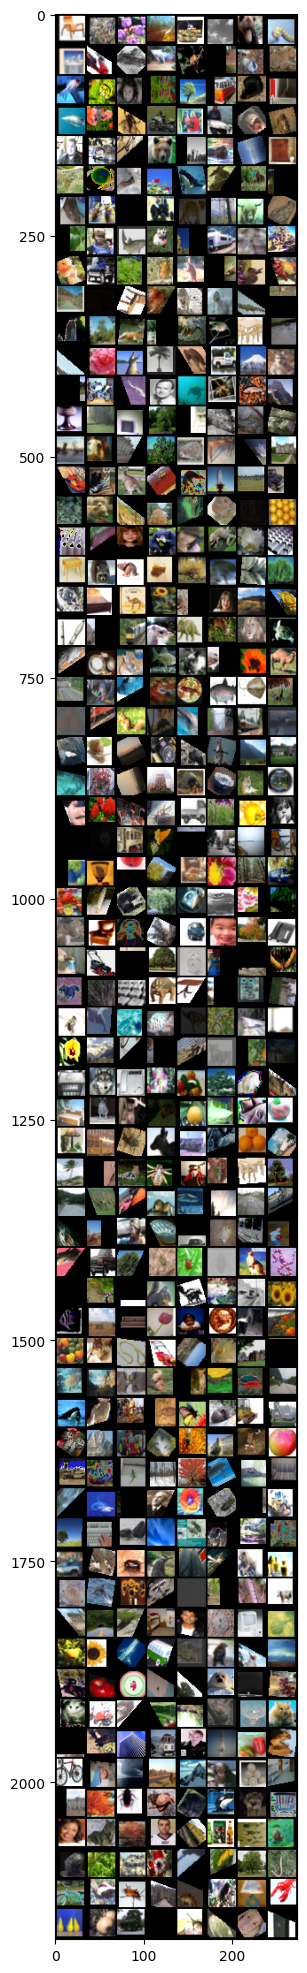

chair orchid tulip ray   tank  cloud bear  snake television motorcycle tank  aquarium_fish mouse tractor rabbit leopard aquarium_fish caterpillar girl  sweet_pepper pine_tree bus   mouse rabbit dolphin poppy beetle motorcycle bee   flatfish chimpanzee lion  man   beaver camel bear  castle beaver sea   wardrobe tiger orange crab  rose  whale kangaroo lion  aquarium_fish mouse pear  pickup_truck tractor lion  forest cattle crocodile sweet_pepper lawn_mower trout mouse sunflower train spider maple_tree aquarium_fish pickup_truck willow_tree mouse kangaroo beaver rabbit crab  road  orange chair leopard wolf  seal  crocodile rabbit skyscraper pine_tree kangaroo tank  crocodile mouse table spider train tulip crocodile palm_tree elephant pickup_truck mountain kangaroo road  motorcycle lizard man   turtle lobster trout mountain cup   willow_tree television willow_tree chair crocodile crocodile forest bridge camel castle pine_tree porcupine table mouse castle lobster tiger kangaroo spider beave

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 25))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(custom_trainloader)
# images, labels, confidences = next(dataiter)

# if training baseline model, uncomment this
dataiter = iter(baseline_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels 
# if isinstance(confidences, list):
#     # in case we have confidence 
#     confidences = confidences[1]
    
# print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=100):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=100, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=100)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = 200
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    
    net.train()
    for i, (inputs, labels) in enumerate(baseline_trainloader):
#     for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # when the model returns [augmentation_magnitude, confidence_aa], which is the case
#         only when TA with soft labels is applied
#         if isinstance(confidences, list):
#             confidences = confidences[1]
            
        # get the inputs
#         inputs, labels, confidences = inputs.to(device), labels.to(device), confidences.to(device)
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
#         labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)  
#         loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#         print(f'Loss: {loss:.3f}\tHard Loss: {hard_loss:.3f}')

        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
#     average_loss = running_loss / len(custom_trainloader)
    average_loss = running_loss / len(baseline_trainloader)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * correct / total: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = '/kaggle/working/cifar100_net_ta_baseline_200.pth'
torch.save(net.state_dict(), PATH)


Start Training...




Epoch 1 - Loss: 4.290 - Test Accuracy:  5.030

Processing time:  68.808920 seconds.



Epoch 2 - Loss: 3.982 - Test Accuracy:  7.990

Processing time:  37.242816 seconds.



Epoch 3 - Loss: 3.780 - Test Accuracy:  12.830

Processing time:  17.910230 seconds.



Epoch 4 - Loss: 3.564 - Test Accuracy:  15.640

Processing time:  17.815297 seconds.



Epoch 5 - Loss: 3.324 - Test Accuracy:  19.650

Processing time:  17.887388 seconds.



Epoch 6 - Loss: 3.110 - Test Accuracy:  21.410

Processing time:  17.789408 seconds.



Epoch 7 - Loss: 2.931 - Test Accuracy:  18.970

Processing time:  17.921813 seconds.



Epoch 8 - Loss: 2.784 - Test Accuracy:  20.850

Processing time:  17.761047 seconds.



Epoch 9 - Loss: 2.625 - Test Accuracy:  23.190

Processing time:  17.932697 seconds.



Epoch 10 - Loss: 2.517 - Test Accuracy:  29.370

Processing time:  17.867707 seconds.



Epoch 11 - Loss: 2.404 - Test Accuracy:  42.270

Processing time:  17.984069 seconds.



Epoch 12 - Loss: 2.315 - Test Accuracy:  39.850

Processing time:  17.877236 seconds.



Epoch 13 - Loss: 2.235 - Test Accuracy:  45.640

Processing time:  17.786808 seconds.



Epoch 14 - Loss: 2.147 - Test Accuracy:  41.000

Processing time:  17.731526 seconds.



Epoch 15 - Loss: 2.082 - Test Accuracy:  37.720

Processing time:  17.866976 seconds.



Epoch 16 - Loss: 2.021 - Test Accuracy:  47.460

Processing time:  17.908996 seconds.



Epoch 17 - Loss: 1.960 - Test Accuracy:  45.950

Processing time:  17.839940 seconds.



Epoch 18 - Loss: 1.913 - Test Accuracy:  51.330

Processing time:  17.767127 seconds.



Epoch 19 - Loss: 1.859 - Test Accuracy:  53.570

Processing time:  17.828933 seconds.



Epoch 20 - Loss: 1.828 - Test Accuracy:  48.530

Processing time:  17.918246 seconds.



Epoch 21 - Loss: 1.781 - Test Accuracy:  57.380

Processing time:  17.851005 seconds.



Epoch 22 - Loss: 1.740 - Test Accuracy:  56.610

Processing time:  17.890512 seconds.



Epoch 23 - Loss: 1.712 - Test Accuracy:  54.870

Processing time:  17.738409 seconds.



Epoch 24 - Loss: 1.674 - Test Accuracy:  53.880

Processing time:  17.848657 seconds.



Epoch 25 - Loss: 1.638 - Test Accuracy:  54.740

Processing time:  17.814188 seconds.



Epoch 26 - Loss: 1.602 - Test Accuracy:  56.060

Processing time:  17.797345 seconds.



Epoch 27 - Loss: 1.587 - Test Accuracy:  62.060

Processing time:  17.553945 seconds.



Epoch 28 - Loss: 1.551 - Test Accuracy:  60.310

Processing time:  17.571579 seconds.



Epoch 29 - Loss: 1.531 - Test Accuracy:  60.910

Processing time:  17.625602 seconds.



Epoch 30 - Loss: 1.513 - Test Accuracy:  60.160

Processing time:  17.942404 seconds.



Epoch 31 - Loss: 1.484 - Test Accuracy:  57.700

Processing time:  17.698949 seconds.



Epoch 32 - Loss: 1.465 - Test Accuracy:  62.250

Processing time:  17.950206 seconds.



Epoch 33 - Loss: 1.455 - Test Accuracy:  63.080

Processing time:  17.664771 seconds.



Epoch 34 - Loss: 1.425 - Test Accuracy:  61.990

Processing time:  17.523727 seconds.



Epoch 35 - Loss: 1.407 - Test Accuracy:  64.880

Processing time:  17.855415 seconds.



Epoch 36 - Loss: 1.388 - Test Accuracy:  61.330

Processing time:  18.042491 seconds.



Epoch 37 - Loss: 1.386 - Test Accuracy:  63.970

Processing time:  17.811862 seconds.



Epoch 38 - Loss: 1.374 - Test Accuracy:  60.990

Processing time:  17.919765 seconds.



Epoch 39 - Loss: 1.348 - Test Accuracy:  65.380

Processing time:  17.958060 seconds.



Epoch 40 - Loss: 1.334 - Test Accuracy:  62.360

Processing time:  18.115596 seconds.



Epoch 41 - Loss: 1.320 - Test Accuracy:  64.750

Processing time:  17.699395 seconds.



Epoch 42 - Loss: 1.307 - Test Accuracy:  66.130

Processing time:  17.923878 seconds.



Epoch 43 - Loss: 1.290 - Test Accuracy:  63.670

Processing time:  18.042049 seconds.



Epoch 44 - Loss: 1.291 - Test Accuracy:  66.660

Processing time:  17.869066 seconds.



Epoch 45 - Loss: 1.262 - Test Accuracy:  63.740

Processing time:  17.968855 seconds.



Epoch 46 - Loss: 1.270 - Test Accuracy:  63.750

Processing time:  17.786612 seconds.



Epoch 47 - Loss: 1.248 - Test Accuracy:  67.800

Processing time:  17.949288 seconds.



Epoch 48 - Loss: 1.227 - Test Accuracy:  65.440

Processing time:  17.817981 seconds.



Epoch 49 - Loss: 1.229 - Test Accuracy:  68.230

Processing time:  17.902283 seconds.



Epoch 50 - Loss: 1.212 - Test Accuracy:  67.000

Processing time:  18.256880 seconds.



Epoch 51 - Loss: 1.201 - Test Accuracy:  66.570

Processing time:  17.909500 seconds.



Epoch 52 - Loss: 1.194 - Test Accuracy:  67.510

Processing time:  17.824140 seconds.



Epoch 53 - Loss: 1.187 - Test Accuracy:  66.540

Processing time:  17.809808 seconds.



Epoch 54 - Loss: 1.165 - Test Accuracy:  67.940

Processing time:  17.800172 seconds.



Epoch 55 - Loss: 1.160 - Test Accuracy:  65.610

Processing time:  17.483711 seconds.



Epoch 56 - Loss: 1.160 - Test Accuracy:  67.400

Processing time:  18.335495 seconds.



Epoch 57 - Loss: 1.137 - Test Accuracy:  67.410

Processing time:  17.628662 seconds.



Epoch 58 - Loss: 1.135 - Test Accuracy:  62.630

Processing time:  18.135936 seconds.



Epoch 59 - Loss: 1.125 - Test Accuracy:  68.550

Processing time:  18.411057 seconds.



Epoch 60 - Loss: 1.121 - Test Accuracy:  67.240

Processing time:  17.950604 seconds.



Epoch 61 - Loss: 1.108 - Test Accuracy:  68.220

Processing time:  18.060845 seconds.



Epoch 62 - Loss: 1.095 - Test Accuracy:  67.230

Processing time:  17.923854 seconds.



Epoch 63 - Loss: 1.087 - Test Accuracy:  69.620

Processing time:  18.016634 seconds.



Epoch 64 - Loss: 1.083 - Test Accuracy:  69.540

Processing time:  17.966398 seconds.



Epoch 65 - Loss: 1.067 - Test Accuracy:  68.050

Processing time:  17.748019 seconds.



Epoch 66 - Loss: 1.066 - Test Accuracy:  69.560

Processing time:  17.777871 seconds.



Epoch 67 - Loss: 1.049 - Test Accuracy:  67.050

Processing time:  17.892467 seconds.



Epoch 68 - Loss: 1.038 - Test Accuracy:  67.920

Processing time:  17.860677 seconds.



Epoch 69 - Loss: 1.056 - Test Accuracy:  69.160

Processing time:  17.895465 seconds.



Epoch 70 - Loss: 1.028 - Test Accuracy:  71.000

Processing time:  17.891577 seconds.



Epoch 71 - Loss: 1.032 - Test Accuracy:  69.530

Processing time:  17.871760 seconds.



Epoch 72 - Loss: 1.025 - Test Accuracy:  67.290

Processing time:  17.934857 seconds.



Epoch 73 - Loss: 1.007 - Test Accuracy:  69.510

Processing time:  17.790208 seconds.



Epoch 74 - Loss: 1.005 - Test Accuracy:  68.690

Processing time:  17.837768 seconds.



Epoch 75 - Loss: 1.002 - Test Accuracy:  67.950

Processing time:  17.892985 seconds.



Epoch 76 - Loss: 0.995 - Test Accuracy:  69.140

Processing time:  17.859035 seconds.



Epoch 77 - Loss: 0.971 - Test Accuracy:  66.260

Processing time:  17.775711 seconds.



Epoch 78 - Loss: 0.984 - Test Accuracy:  71.150

Processing time:  17.852379 seconds.



Epoch 79 - Loss: 0.976 - Test Accuracy:  68.750

Processing time:  17.871945 seconds.



Epoch 80 - Loss: 0.970 - Test Accuracy:  68.510

Processing time:  19.549348 seconds.



Epoch 81 - Loss: 0.951 - Test Accuracy:  70.520

Processing time:  17.949226 seconds.



Epoch 82 - Loss: 0.945 - Test Accuracy:  71.090

Processing time:  17.836359 seconds.



Epoch 83 - Loss: 0.948 - Test Accuracy:  70.310

Processing time:  17.886461 seconds.



Epoch 84 - Loss: 0.939 - Test Accuracy:  69.910

Processing time:  18.012956 seconds.



Epoch 85 - Loss: 0.924 - Test Accuracy:  70.770

Processing time:  17.947582 seconds.



Epoch 86 - Loss: 0.916 - Test Accuracy:  70.440

Processing time:  17.714289 seconds.



Epoch 87 - Loss: 0.906 - Test Accuracy:  69.820

Processing time:  18.082684 seconds.



Epoch 88 - Loss: 0.911 - Test Accuracy:  71.550

Processing time:  17.958704 seconds.



Epoch 89 - Loss: 0.898 - Test Accuracy:  68.460

Processing time:  17.789829 seconds.



Epoch 90 - Loss: 0.902 - Test Accuracy:  69.710

Processing time:  17.940729 seconds.



Epoch 91 - Loss: 0.897 - Test Accuracy:  71.970

Processing time:  17.812342 seconds.



Epoch 92 - Loss: 0.885 - Test Accuracy:  70.370

Processing time:  17.913777 seconds.



Epoch 93 - Loss: 0.865 - Test Accuracy:  72.240

Processing time:  18.111324 seconds.



Epoch 94 - Loss: 0.868 - Test Accuracy:  71.320

Processing time:  18.006714 seconds.



Epoch 95 - Loss: 0.857 - Test Accuracy:  71.720

Processing time:  19.088577 seconds.



Epoch 96 - Loss: 0.862 - Test Accuracy:  72.620

Processing time:  17.920240 seconds.



Epoch 97 - Loss: 0.848 - Test Accuracy:  72.940

Processing time:  17.599526 seconds.



Epoch 98 - Loss: 0.840 - Test Accuracy:  70.130

Processing time:  18.053529 seconds.



Epoch 99 - Loss: 0.835 - Test Accuracy:  71.920

Processing time:  18.035231 seconds.



Epoch 100 - Loss: 0.832 - Test Accuracy:  73.170

Processing time:  18.055254 seconds.



Epoch 101 - Loss: 0.821 - Test Accuracy:  73.380

Processing time:  18.001322 seconds.



Epoch 102 - Loss: 0.819 - Test Accuracy:  72.460

Processing time:  19.020834 seconds.



Epoch 103 - Loss: 0.815 - Test Accuracy:  72.640

Processing time:  17.971577 seconds.



Epoch 104 - Loss: 0.812 - Test Accuracy:  73.520

Processing time:  17.930470 seconds.



Epoch 105 - Loss: 0.802 - Test Accuracy:  72.730

Processing time:  17.914864 seconds.



Epoch 106 - Loss: 0.802 - Test Accuracy:  73.240

Processing time:  17.948239 seconds.



Epoch 107 - Loss: 0.792 - Test Accuracy:  73.310

Processing time:  17.890005 seconds.



Epoch 108 - Loss: 0.790 - Test Accuracy:  73.290

Processing time:  17.849211 seconds.



Epoch 109 - Loss: 0.788 - Test Accuracy:  72.110

Processing time:  18.890893 seconds.



Epoch 110 - Loss: 0.767 - Test Accuracy:  73.580

Processing time:  17.770557 seconds.



Epoch 111 - Loss: 0.777 - Test Accuracy:  73.570

Processing time:  17.990637 seconds.



Epoch 112 - Loss: 0.766 - Test Accuracy:  73.580

Processing time:  17.785995 seconds.



Epoch 113 - Loss: 0.743 - Test Accuracy:  73.300

Processing time:  18.265423 seconds.



Epoch 114 - Loss: 0.743 - Test Accuracy:  72.890

Processing time:  17.794940 seconds.



Epoch 115 - Loss: 0.738 - Test Accuracy:  72.450

Processing time:  18.086665 seconds.



Epoch 116 - Loss: 0.735 - Test Accuracy:  73.460

Processing time:  17.808379 seconds.



Epoch 117 - Loss: 0.737 - Test Accuracy:  74.630

Processing time:  17.822728 seconds.



Epoch 118 - Loss: 0.723 - Test Accuracy:  74.990

Processing time:  17.779511 seconds.



Epoch 119 - Loss: 0.719 - Test Accuracy:  74.690

Processing time:  17.803381 seconds.



Epoch 120 - Loss: 0.717 - Test Accuracy:  74.750

Processing time:  17.909130 seconds.



Epoch 121 - Loss: 0.708 - Test Accuracy:  74.690

Processing time:  17.956878 seconds.



Epoch 122 - Loss: 0.707 - Test Accuracy:  75.380

Processing time:  17.792323 seconds.



Epoch 123 - Loss: 0.699 - Test Accuracy:  74.700

Processing time:  17.735200 seconds.



Epoch 124 - Loss: 0.691 - Test Accuracy:  75.260

Processing time:  17.883942 seconds.



Epoch 125 - Loss: 0.692 - Test Accuracy:  74.600

Processing time:  18.009268 seconds.



Epoch 126 - Loss: 0.685 - Test Accuracy:  73.520

Processing time:  19.230348 seconds.



Epoch 127 - Loss: 0.685 - Test Accuracy:  75.460

Processing time:  17.848898 seconds.



Epoch 128 - Loss: 0.680 - Test Accuracy:  74.810

Processing time:  18.144061 seconds.



Epoch 129 - Loss: 0.681 - Test Accuracy:  74.770

Processing time:  17.959774 seconds.



Epoch 130 - Loss: 0.664 - Test Accuracy:  74.310

Processing time:  18.470928 seconds.



Epoch 131 - Loss: 0.657 - Test Accuracy:  74.740

Processing time:  18.002855 seconds.



Epoch 132 - Loss: 0.654 - Test Accuracy:  74.940

Processing time:  19.531808 seconds.



Epoch 133 - Loss: 0.647 - Test Accuracy:  75.620

Processing time:  17.931937 seconds.



Epoch 134 - Loss: 0.636 - Test Accuracy:  75.430

Processing time:  19.128129 seconds.



Epoch 135 - Loss: 0.631 - Test Accuracy:  74.240

Processing time:  17.701467 seconds.



Epoch 136 - Loss: 0.638 - Test Accuracy:  75.620

Processing time:  17.912602 seconds.



Epoch 137 - Loss: 0.618 - Test Accuracy:  76.120

Processing time:  17.855641 seconds.



Epoch 138 - Loss: 0.618 - Test Accuracy:  75.650

Processing time:  17.904620 seconds.



Epoch 139 - Loss: 0.620 - Test Accuracy:  74.740

Processing time:  18.934225 seconds.



Epoch 140 - Loss: 0.615 - Test Accuracy:  76.000

Processing time:  17.830231 seconds.



Epoch 141 - Loss: 0.611 - Test Accuracy:  76.890

Processing time:  17.907781 seconds.



Epoch 142 - Loss: 0.605 - Test Accuracy:  76.770

Processing time:  17.871970 seconds.



Epoch 143 - Loss: 0.601 - Test Accuracy:  76.440

Processing time:  18.005473 seconds.



Epoch 144 - Loss: 0.587 - Test Accuracy:  76.570

Processing time:  17.903015 seconds.



Epoch 145 - Loss: 0.585 - Test Accuracy:  76.820

Processing time:  17.769184 seconds.



Epoch 146 - Loss: 0.586 - Test Accuracy:  76.740

Processing time:  17.827976 seconds.



Epoch 147 - Loss: 0.579 - Test Accuracy:  77.310

Processing time:  19.072162 seconds.



Epoch 148 - Loss: 0.577 - Test Accuracy:  76.820

Processing time:  17.752628 seconds.



Epoch 149 - Loss: 0.575 - Test Accuracy:  76.950

Processing time:  17.729305 seconds.



Epoch 150 - Loss: 0.567 - Test Accuracy:  76.840

Processing time:  17.942401 seconds.



Epoch 151 - Loss: 0.556 - Test Accuracy:  77.260

Processing time:  17.814304 seconds.



Epoch 152 - Loss: 0.556 - Test Accuracy:  76.890

Processing time:  17.726197 seconds.



Epoch 153 - Loss: 0.557 - Test Accuracy:  76.960

Processing time:  17.871597 seconds.



Epoch 154 - Loss: 0.561 - Test Accuracy:  76.660

Processing time:  17.793639 seconds.



Epoch 155 - Loss: 0.546 - Test Accuracy:  76.790

Processing time:  17.749933 seconds.



Epoch 156 - Loss: 0.544 - Test Accuracy:  77.030

Processing time:  17.813275 seconds.



Epoch 157 - Loss: 0.539 - Test Accuracy:  76.980

Processing time:  18.028255 seconds.



Epoch 158 - Loss: 0.541 - Test Accuracy:  76.770

Processing time:  17.807585 seconds.



Epoch 159 - Loss: 0.541 - Test Accuracy:  76.480

Processing time:  17.863039 seconds.



Epoch 160 - Loss: 0.529 - Test Accuracy:  76.980

Processing time:  17.713553 seconds.



Epoch 161 - Loss: 0.521 - Test Accuracy:  77.670

Processing time:  19.230722 seconds.



Epoch 162 - Loss: 0.520 - Test Accuracy:  77.290

Processing time:  17.994295 seconds.



Epoch 163 - Loss: 0.517 - Test Accuracy:  77.490

Processing time:  18.144679 seconds.



Epoch 164 - Loss: 0.521 - Test Accuracy:  77.470

Processing time:  18.219239 seconds.



Epoch 165 - Loss: 0.515 - Test Accuracy:  77.980

Processing time:  17.974937 seconds.



Epoch 166 - Loss: 0.518 - Test Accuracy:  77.380

Processing time:  17.795925 seconds.



Epoch 167 - Loss: 0.511 - Test Accuracy:  78.080

Processing time:  18.067351 seconds.



Epoch 168 - Loss: 0.511 - Test Accuracy:  77.790

Processing time:  18.943613 seconds.



Epoch 169 - Loss: 0.501 - Test Accuracy:  77.660

Processing time:  19.377872 seconds.



Epoch 170 - Loss: 0.500 - Test Accuracy:  77.780

Processing time:  18.685579 seconds.



Epoch 171 - Loss: 0.507 - Test Accuracy:  77.740

Processing time:  19.769818 seconds.



Epoch 172 - Loss: 0.492 - Test Accuracy:  77.990

Processing time:  17.982322 seconds.



Epoch 173 - Loss: 0.496 - Test Accuracy:  77.540

Processing time:  17.782777 seconds.



Epoch 174 - Loss: 0.490 - Test Accuracy:  77.860

Processing time:  18.031555 seconds.



Epoch 175 - Loss: 0.491 - Test Accuracy:  77.980

Processing time:  19.421428 seconds.



Epoch 176 - Loss: 0.483 - Test Accuracy:  78.320

Processing time:  17.838112 seconds.



Epoch 177 - Loss: 0.480 - Test Accuracy:  78.030

Processing time:  17.965669 seconds.



Epoch 178 - Loss: 0.491 - Test Accuracy:  78.020

Processing time:  17.939615 seconds.



Epoch 179 - Loss: 0.482 - Test Accuracy:  78.250

Processing time:  17.775435 seconds.



Epoch 180 - Loss: 0.486 - Test Accuracy:  78.160

Processing time:  17.743686 seconds.



Epoch 181 - Loss: 0.485 - Test Accuracy:  78.400

Processing time:  17.510825 seconds.



Epoch 182 - Loss: 0.494 - Test Accuracy:  78.100

Processing time:  17.566147 seconds.



Epoch 183 - Loss: 0.477 - Test Accuracy:  78.250

Processing time:  17.507200 seconds.



Epoch 184 - Loss: 0.477 - Test Accuracy:  78.080

Processing time:  17.548799 seconds.



Epoch 185 - Loss: 0.462 - Test Accuracy:  78.280

Processing time:  17.561836 seconds.



Epoch 186 - Loss: 0.479 - Test Accuracy:  78.230

Processing time:  18.003264 seconds.



Epoch 187 - Loss: 0.464 - Test Accuracy:  78.380

Processing time:  18.752043 seconds.



Epoch 188 - Loss: 0.475 - Test Accuracy:  78.230

Processing time:  17.891060 seconds.



Epoch 189 - Loss: 0.463 - Test Accuracy:  78.220

Processing time:  17.890999 seconds.



Epoch 190 - Loss: 0.460 - Test Accuracy:  78.190

Processing time:  17.807158 seconds.



Epoch 191 - Loss: 0.464 - Test Accuracy:  78.300

Processing time:  20.178462 seconds.



Epoch 192 - Loss: 0.462 - Test Accuracy:  78.310

Processing time:  17.926289 seconds.



Epoch 193 - Loss: 0.467 - Test Accuracy:  78.290

Processing time:  18.312226 seconds.



Epoch 194 - Loss: 0.469 - Test Accuracy:  78.450

Processing time:  17.930072 seconds.



Epoch 195 - Loss: 0.471 - Test Accuracy:  78.340

Processing time:  18.323395 seconds.



Epoch 196 - Loss: 0.472 - Test Accuracy:  78.220

Processing time:  17.980174 seconds.



Epoch 197 - Loss: 0.455 - Test Accuracy:  78.590

Processing time:  17.872613 seconds.



Epoch 198 - Loss: 0.468 - Test Accuracy:  78.260

Processing time:  18.604970 seconds.



Epoch 199 - Loss: 0.457 - Test Accuracy:  78.350

Processing time:  18.701496 seconds.



Epoch 200 - Loss: 0.474 - Test Accuracy:  78.430

Processing time:  18.764066 seconds.
Finished Training


Evaluate the model on Testset

In [10]:
import torch
import numpy as np

# Evaluate the CIFAR-100 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-100 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-100 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-100 test dataset: 78.43 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 57.98 %


Accuracy of the network on gaussian_noise dataset split 2: 41.95 %


Accuracy of the network on gaussian_noise dataset split 3: 28.92 %


Accuracy of the network on gaussian_noise dataset split 4: 24.50 %


Accuracy of the network on gaussian_noise dataset split 5: 19.72 %
Average accuracy for gaussian_noise dataset: 34.61 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 64.66 %


Accuracy of the network on shot_noise dataset split 2: 56.34 %


Accuracy of the network on shot_noise dataset split 3: 38.25 %


Accuracy of the network on shot_noise dataset split 4: 32.04 %


Accuracy of the network on shot_noise dataset split 5: 23.24 %
Average accuracy for shot_noise dataset: 42.91 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 73.27 %


Accuracy of the network on impulse_noise dataset split 2: 66.53 %


Accuracy of the network on impulse_noise dataset split 3: 57.47 %


Accuracy of the network on impulse_noise dataset split 4: 38.06 %


Accuracy of the network on impulse_noise dataset split 5: 23.30 %
Average accuracy for impulse_noise dataset: 51.73 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 77.91 %


Accuracy of the network on defocus_blur dataset split 2: 76.10 %


Accuracy of the network on defocus_blur dataset split 3: 73.40 %


Accuracy of the network on defocus_blur dataset split 4: 68.20 %


Accuracy of the network on defocus_blur dataset split 5: 55.43 %
Average accuracy for defocus_blur dataset: 70.21 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 50.27 %


Accuracy of the network on glass_blur dataset split 2: 52.54 %


Accuracy of the network on glass_blur dataset split 3: 54.25 %


Accuracy of the network on glass_blur dataset split 4: 35.27 %


Accuracy of the network on glass_blur dataset split 5: 38.05 %
Average accuracy for glass_blur dataset: 46.08 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 72.99 %


Accuracy of the network on motion_blur dataset split 2: 66.28 %


Accuracy of the network on motion_blur dataset split 3: 58.20 %


Accuracy of the network on motion_blur dataset split 4: 58.48 %


Accuracy of the network on motion_blur dataset split 5: 49.68 %
Average accuracy for motion_blur dataset: 61.13 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 72.42 %


Accuracy of the network on zoom_blur dataset split 2: 71.63 %


Accuracy of the network on zoom_blur dataset split 3: 68.62 %


Accuracy of the network on zoom_blur dataset split 4: 64.66 %


Accuracy of the network on zoom_blur dataset split 5: 58.26 %
Average accuracy for zoom_blur dataset: 67.12 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 73.98 %


Accuracy of the network on snow dataset split 2: 63.87 %


Accuracy of the network on snow dataset split 3: 64.95 %


Accuracy of the network on snow dataset split 4: 61.63 %


Accuracy of the network on snow dataset split 5: 54.52 %
Average accuracy for snow dataset: 63.79 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 70.64 %


Accuracy of the network on frost dataset split 2: 63.35 %


Accuracy of the network on frost dataset split 3: 52.75 %


Accuracy of the network on frost dataset split 4: 50.14 %


Accuracy of the network on frost dataset split 5: 40.90 %
Average accuracy for frost dataset: 55.56 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 77.59 %


Accuracy of the network on fog dataset split 2: 74.98 %


Accuracy of the network on fog dataset split 3: 72.00 %


Accuracy of the network on fog dataset split 4: 65.05 %


Accuracy of the network on fog dataset split 5: 43.20 %
Average accuracy for fog dataset: 66.56 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 78.34 %


Accuracy of the network on brightness dataset split 2: 77.92 %


Accuracy of the network on brightness dataset split 3: 77.20 %


Accuracy of the network on brightness dataset split 4: 76.06 %


Accuracy of the network on brightness dataset split 5: 71.82 %
Average accuracy for brightness dataset: 76.27 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 77.08 %


Accuracy of the network on contrast dataset split 2: 73.01 %


Accuracy of the network on contrast dataset split 3: 70.61 %


Accuracy of the network on contrast dataset split 4: 66.86 %


Accuracy of the network on contrast dataset split 5: 54.25 %
Average accuracy for contrast dataset: 68.36 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 71.45 %


Accuracy of the network on elastic_transform dataset split 2: 72.00 %


Accuracy of the network on elastic_transform dataset split 3: 69.18 %


Accuracy of the network on elastic_transform dataset split 4: 61.31 %


Accuracy of the network on elastic_transform dataset split 5: 51.78 %
Average accuracy for elastic_transform dataset: 65.14 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 75.48 %


Accuracy of the network on pixelate dataset split 2: 69.66 %


Accuracy of the network on pixelate dataset split 3: 65.08 %


Accuracy of the network on pixelate dataset split 4: 47.31 %


Accuracy of the network on pixelate dataset split 5: 21.73 %
Average accuracy for pixelate dataset: 55.85 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 60.78 %


Accuracy of the network on jpeg_compression dataset split 2: 53.18 %


Accuracy of the network on jpeg_compression dataset split 3: 50.33 %


Accuracy of the network on jpeg_compression dataset split 4: 47.59 %


Accuracy of the network on jpeg_compression dataset split 5: 44.39 %
Average accuracy for jpeg_compression dataset: 51.25 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 65.60 %


Accuracy of the network on speckle_noise dataset split 2: 51.89 %


Accuracy of the network on speckle_noise dataset split 3: 44.95 %


Accuracy of the network on speckle_noise dataset split 4: 33.04 %


Accuracy of the network on speckle_noise dataset split 5: 25.32 %
Average accuracy for speckle_noise dataset: 44.16 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 78.00 %


Accuracy of the network on gaussian_blur dataset split 2: 73.21 %


Accuracy of the network on gaussian_blur dataset split 3: 68.84 %


Accuracy of the network on gaussian_blur dataset split 4: 63.85 %


Accuracy of the network on gaussian_blur dataset split 5: 50.98 %
Average accuracy for gaussian_blur dataset: 66.98 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 76.31 %


Accuracy of the network on spatter dataset split 2: 71.57 %


Accuracy of the network on spatter dataset split 3: 65.29 %


Accuracy of the network on spatter dataset split 4: 70.90 %


Accuracy of the network on spatter dataset split 5: 62.13 %
Average accuracy for spatter dataset: 69.24 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 71.83 %


Accuracy of the network on saturate dataset split 2: 65.82 %


Accuracy of the network on saturate dataset split 3: 76.66 %


Accuracy of the network on saturate dataset split 4: 70.71 %


Accuracy of the network on saturate dataset split 5: 63.69 %
Average accuracy for saturate dataset: 69.74 %
Average Robust Accuracy: 59.30 %
